# Simulating pore with varying tether length and sequences

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
'''
Initialise functions for plotting and processing data
'''

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video


#centre of barrel
xc = (60.57 + 39.43)/2
yc = 50
zc = 50
lengthToNm = 0.8518 
timeTons   = 3.03e-3
barHeight = 61.05


def getPoreNt(teth_len):
    scaf_start = 0
    scaf_end   = 593-40 + teth_len*2
    return np.arange(teth_len + scaf_start, scaf_end - teth_len)
    
    
def getTopNt(teth_len):
    return teth_len
    
def getMidNt(teth_len):
    return teth_len + 44

def getBotNt(teth_len):
    return teth_len + 89
    
    
def RMS(x, y, z):
    #takes a vector (e.g. velocity) broken into components x,y,z and returns the RMS value
    return np.sqrt(x**2 + y**2 + z**2)


def getPosition(data, nt, pos, vel, rot):
    #takes data and returns position in nm relative to centre of barrel
    xpos = data[:,0 + 3*nt*(pos + vel + rot)] 
    ypos = data[:,1 + 3*nt*(pos + vel + rot)] 
    zpos = data[:,2 + 3*nt*(pos + vel + rot)] 
    xpos = (xpos - xc)*lengthToNm
    ypos = (ypos - yc)*lengthToNm
    zpos = (zpos - zc)*lengthToNm
    return [xpos, ypos, zpos]

def getVelocity(data, nt, pos, vel, rot):
    #takes data and returns velocity in nm/ns relative to centre of barrel
    xvel = data[:,3 + 3*nt*(pos + vel + rot)] 
    yvel = data[:,4 + 3*nt*(pos + vel + rot)] 
    zvel = data[:,5 + 3*nt*(pos + vel + rot)] 
    xvel = xvel*lengthToNm/timeTons
    yvel = yvel*lengthToNm/timeTons
    zvel = zvel*lengthToNm/timeTons
    return [xvel, yvel, zvel]


def getAngularV(data, nt, pos, vel, rot):
    #takes data and returns angular velocity in 1/ns relative to centre of barrel
    xrot = data[:,6 + 3*nt*(pos + vel + rot)] 
    yrot = data[:,7 + 3*nt*(pos + vel + rot)] 
    zrot = data[:,8 + 3*nt*(pos + vel + rot)] 
    xrot = xrot/timeTons/np.pi*180
    yrot = yrot/timeTons/np.pi*180
    zrot = zrot/timeTons/np.pi*180
    return [xrot, yrot, zrot]


def takeMean(Vec):
    #given a list takes the mean along each coordinate
    for i in range(len(Vec)):
        Vec[i] = np.mean(Vec[i],1)
    return Vec


def takeMin(Vec):
    for i in range(len(Vec)):
        Vec[i] = np.array(Vec[i]).min(1)
    return Vec   
    
def takeMax(Vec):
    for i in range(len(Vec)):
        Vec[i] = np.array(Vec[i]).max(1)
    return Vec

def cartToCyl(x,y,z):
    #converts Cartesian coords to cylindrical coordinates in degrees
    r     = np.sqrt(x**2 + y**2)
    theta = np.arctan2(posV[1], posV[0])/np.pi*180
    return [r, theta, z]


def plotPositionHist(posV, pType = 'z', title = None, vline = None):
    '''
    plots the histogram of a spatial or angular coordinate
    posV is the position vector
    pType = 'x', 'y', 'z', 't' (theta), 'r' (radial)
    '''   
    plt.figure()
    plt.xlabel('Position (nm)')
    if pType == 'x':
        pos = posV[0]
        plt.title('Histogram of location of pore - x-position')
    elif pType == 'y':
        pos = posV[1]
        plt.title('Histogram of location of pore - y-position')        
    elif pType == 'z':
        pos = posV[2]
        plt.title('Histogram of location of pore - z-position')
    elif pType == 'r':
        pos = np.sqrt(posV[0]**2 + posV[1]**2)
        plt.title('Histogram of location of pore - r-position')
        plt.xlabel('Radial distance from centre of pore (nm)')
    elif pType == 't':
        pos = np.arctan2(posV[1], posV[0])/np.pi*180     
        plt.title('Histogram of location of pore - angular distance of pore in barrel')
        plt.xlabel('Angular distance of pore in barrel (degrees)')

    if title is not None:
        plt.title(title)
        
    plt.hist(pos, density = True, bins = int(np.sqrt(len(pos))))
    
    xmin, xmax, ymin, ymax = plt.axis()    
    if vline is not None:
        plt.vlines(vline, 0, ymax, 'r')
    plt.ylabel('Probability density')
    plt.show()
    
    
def plotRMSHist(Vec, pType = 'vel'):
    '''
    plots the histogram of a spatial or angular coordinate
    Vec is a vector: either position, velocity or angular velocity
    pType = 'pos', 'vel', 'rot'
    '''       
    RMSVec = RMS(Vec[0], Vec[1], Vec[2])
    plt.figure()
    plt.hist(RMSVec, density = True)
    plt.ylabel('Probability density')

    if pType == 'pos':
        plt.xlabel('Average root mean squared position (nm)')
        plt.title('Histogram of average root mean squared position')
    elif pType == 'vel':
        plt.xlabel('Average root mean squared velocity (nm/ns)')
        plt.title('Histogram of average root mean squared velocity')
    elif pType == 'rot':
        plt.xlabel('Average root mean squared angular velocity (degrees/ns)')
        plt.title('Histogram of average root mean squared angular velocity')
    plt.show()
 

def plotMeanStdPair(xval, Means, Stds, ylabel1 = '', ylabel2 = '', xlabel = 'Tether length (bp)', title = ''):
    plt.figure()
    fig, ax1 = plt.subplots()
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel1, color='b')
    ax1.plot(xval, Means, 'bo')
    ax1.tick_params(axis='y', labelcolor='b')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel(ylabel2, color='r')  
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.plot(xval, Stds, 'rx')
    plt.title(title)
    fig.tight_layout() 
    plt.show()
    
#plot mean-standard deviation pair with error bars
def plotMeanStdEB(xval, Means, Stds, ylabel = '', xlabel = 'Tether length (bp)', title = '', legend = [], hline = None, vline = None):
    plt.figure()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    shapes = ['o', '^', 'D', '*', 's', 'p', 'h']
    if np.ndim(Means) == 1:
        plt.errorbar(xval, Means, Stds, fmt='bo:', label = legend[0])
    else:
        for i in range(np.shape(Means)[1]):
            plt.errorbar(xval, Means[:,i], Stds[:,i], fmt=shapes[i] + ':', label = legend[i])
    
    if hline is not None:
        plt.hlines(hline, xval[0], xval[-1], linestyles='dashed')
    
    xmin, xmax, ymin, ymax = plt.axis()
    if vline is not None:
        plt.vlines(vline, ymin, ymax, linestyles='dashed')

    plt.title(title)
    plt.legend()
    plt.show()    


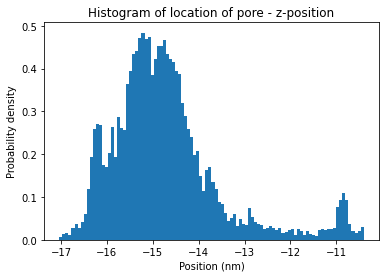

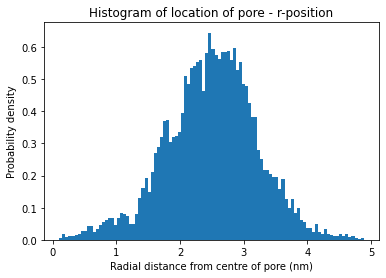

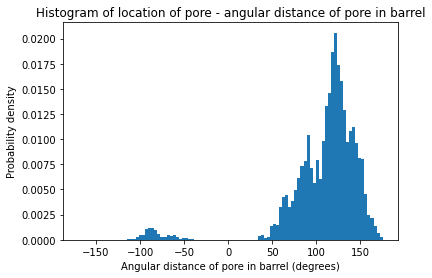

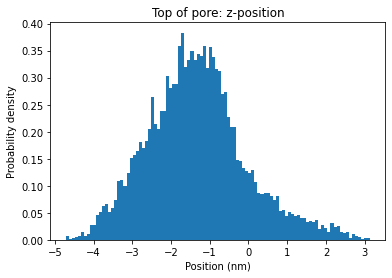

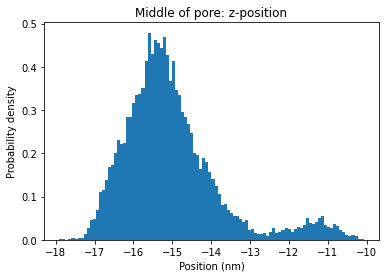

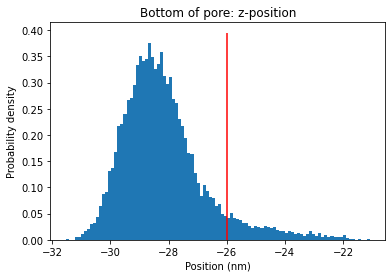

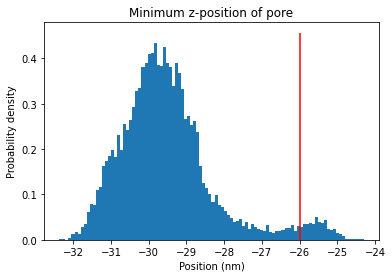

In [3]:
'''
Import data for tether length 60
'''

data = np.genfromtxt('len15/ogSeq/jointpos.dat')

teth_len = 15

#nucleotide to track
nt = getPoreNt(teth_len)

#Get positions
posV = takeMean(getPosition(data, nt, 1, 0, 0))

#Plot histograms
plotPositionHist(posV, 'z')
plotPositionHist(posV, 'r')
plotPositionHist(posV, 't')

#bottom, middle and top of pore
plotPositionHist(getPosition(data, getTopNt(teth_len), 1, 0, 0), 'z', title = 'Top of pore: z-position')
plotPositionHist(getPosition(data, getMidNt(teth_len), 1, 0, 0), 'z', title = 'Middle of pore: z-position')
plotPositionHist(getPosition(data, getBotNt(teth_len), 1, 0, 0), 'z', title = 'Bottom of pore: z-position', vline = -32)
plotPositionHist(takeMin(getPosition(data, nt, 1, 0, 0)), 'z', title = 'Minimum z-position of pore', vline = -32)

In [3]:
'''
Loop over data
'''

teth_lens = list(range(15, 135, 15))
N = len(teth_lens)

poreEnd = 26

ave_z   = np.zeros([N,3])
ave_r   = np.zeros([N,3])
ave_th  = np.zeros([N,3])
std_z   = np.zeros([N,3])
std_r   = np.zeros([N,3])
std_th  = np.zeros([N,3])

ave_top_z   = np.zeros([N,3])
ave_top_r   = np.zeros([N,3])
ave_top_th  = np.zeros([N,3])
std_top_z   = np.zeros([N,3])
std_top_r   = np.zeros([N,3])
std_top_th  = np.zeros([N,3])

ave_mid_z   = np.zeros([N,3])
ave_mid_r   = np.zeros([N,3])
ave_mid_th  = np.zeros([N,3])
std_mid_z   = np.zeros([N,3])
std_mid_r   = np.zeros([N,3])
std_mid_th  = np.zeros([N,3])

ave_bot_z   = np.zeros([N,3])
ave_bot_r   = np.zeros([N,3])
ave_bot_th  = np.zeros([N,3])
std_bot_z   = np.zeros([N,3])
std_bot_r   = np.zeros([N,3])
std_bot_th  = np.zeros([N,3])

ave_min_z   = np.zeros([N,3])
ave_min_r   = np.zeros([N,3])
ave_min_th  = np.zeros([N,3])
std_min_z   = np.zeros([N,3])
std_min_r   = np.zeros([N,3])
std_min_th  = np.zeros([N,3])

ave_bonds   = np.zeros([N,3])
std_bonds   = np.zeros([N,3])


FracOut = np.zeros([N,3])

minBonds = [495, 495, 495] #84*2 is the cinch length
seqNames = ['ogSeq', 'shiftSeq700', 'tethAllT']

for s in range(3):
    for t in range(N):
        print('Now processing :', seqNames[s], teth_lens[t])
        teth_len = teth_lens[t]
        data = np.genfromtxt('len' + str(teth_len) + '/' + seqNames[s] + '/jointpos.dat')

        #nucleotide to track
        nt = getPoreNt(teth_len)
        
        #Get mean positions
        posV = takeMean(getPosition(data, nt, 1, 0, 0))
        
        #if pore is in opposite orientation
        if np.mean(posV[2]) > 0:
            zsign = 1
        else:
            zsign = 1
        
        ave_z[t][s]   = np.mean(posV[2])*zsign
        ave_r[t][s]   = np.mean(cartToCyl(posV[0],posV[1],posV[2])[0])
        ave_th[t][s]  = np.mean(abs(cartToCyl(posV[0],posV[1],posV[2])[1]))
        std_z[t][s]   = np.std(posV[2])
        std_r[t][s]   = np.std(cartToCyl(posV[0],posV[1],posV[2])[0])
        std_th[t][s]  = np.std(abs(cartToCyl(posV[0],posV[1],posV[2])[1]))

        #Get top positions
        posV = getPosition(data, getTopNt(teth_len), 1, 0, 0)
        ave_top_z[t][s]   = np.mean(posV[2])*zsign
        ave_top_r[t][s]   = np.mean(cartToCyl(posV[0],posV[1],posV[2])[0])
        ave_top_th[t][s]  = np.mean(abs(cartToCyl(posV[0],posV[1],posV[2])[1]))
        std_top_z[t][s]   = np.std(posV[2])
        std_top_r[t][s]   = np.std(cartToCyl(posV[0],posV[1],posV[2])[0])
        std_top_th[t][s]  = np.std(abs(cartToCyl(posV[0],posV[1],posV[2])[1]))

        #Get middle positions
        posV = getPosition(data, getMidNt(teth_len), 1, 0, 0)              
        ave_mid_z[t][s]   = np.mean(posV[2])*zsign
        ave_mid_r[t][s]   = np.mean(cartToCyl(posV[0],posV[1],posV[2])[0])
        ave_mid_th[t][s]  = np.mean(abs(cartToCyl(posV[0],posV[1],posV[2])[1]))
        std_mid_z[t][s]   = np.std(posV[2])
        std_mid_r[t][s]   = np.std(cartToCyl(posV[0],posV[1],posV[2])[0])
        std_mid_th[t][s]  = np.std(abs(cartToCyl(posV[0],posV[1],posV[2])[1]))

        #Get bottom positions
        posV = getPosition(data, getBotNt(teth_len), 1, 0, 0)              
        ave_bot_z[t][s]   = np.mean(posV[2])*zsign
        ave_bot_r[t][s]   = np.mean(cartToCyl(posV[0],posV[1],posV[2])[0])
        ave_bot_th[t][s]  = np.mean(abs(cartToCyl(posV[0],posV[1],posV[2])[1]))
        std_bot_z[t][s]   = np.std(posV[2])
        std_bot_r[t][s]   = np.std(cartToCyl(posV[0],posV[1],posV[2])[0])
        std_bot_th[t][s]  = np.std(abs(cartToCyl(posV[0],posV[1],posV[2])[1]))


        #Get minimum positions
        posV = takeMin(getPosition(data, nt, 1, 0, 0))            
        ave_min_z[t][s]   = np.mean(posV[2])*zsign
        ave_min_r[t][s]   = np.mean(cartToCyl(posV[0],posV[1],posV[2])[0])
        ave_min_th[t][s]  = np.mean(abs(cartToCyl(posV[0],posV[1],posV[2])[1]))
        std_min_z[t][s]   = np.std(posV[2])
        std_min_r[t][s]   = np.std(cartToCyl(posV[0],posV[1],posV[2])[0])
        std_min_th[t][s]  = np.std(abs(cartToCyl(posV[0],posV[1],posV[2])[1]))
        
        #fraction of time outside the pore
        FracOut[t][s] = sum(abs(posV[2][i]) > poreEnd  for i in range(len(posV[2])))/len(posV[2])   
        
        #number of bonds
        bonds = np.genfromtxt('len' + str(teth_len) + '/' + seqNames[s] + '/numbonds.txt')
        bonds = bonds - minBonds[s]
        bonds = bonds.clip(min=0)
        ave_bonds[t][s]   = np.mean(bonds)
        std_bonds[t][s]   = np.std(bonds)
        if s == 2:
            ave_bonds[t][s]   = 0
            std_bonds[t][s]   = 0        
        
print('Finished processing')

Now processing : ogSeq 15
Now processing : ogSeq 30
Now processing : ogSeq 45
Now processing : ogSeq 60
Now processing : ogSeq 75
Now processing : ogSeq 90
Now processing : ogSeq 105
Now processing : ogSeq 120
Now processing : shiftSeq700 15
Now processing : shiftSeq700 30
Now processing : shiftSeq700 45
Now processing : shiftSeq700 60
Now processing : shiftSeq700 75
Now processing : shiftSeq700 90
Now processing : shiftSeq700 105
Now processing : shiftSeq700 120
Now processing : tethAllT 15
Now processing : tethAllT 30
Now processing : tethAllT 45
Now processing : tethAllT 60
Now processing : tethAllT 75
Now processing : tethAllT 90
Now processing : tethAllT 105
Now processing : tethAllT 120
Finished processing


In [4]:
#save results to hdf5 file
import h5py

saveName = 'resultsSummary1.hdf5'

with h5py.File(saveName, "a") as f:
    f.create_dataset("teth_lens", data=np.array(teth_lens))
    f.create_dataset("ave_z", data=ave_z)
    f.create_dataset("ave_r", data=ave_r)
    f.create_dataset("ave_th", data=ave_th)
    f.create_dataset("std_z", data=std_z)
    f.create_dataset("std_r", data=std_r)
    f.create_dataset("std_th", data=std_th)
    f.create_dataset("ave_top_z", data=ave_top_z)
    f.create_dataset("ave_top_r", data=ave_top_r)
    f.create_dataset("ave_top_th", data=ave_top_th)
    f.create_dataset("std_top_z", data=std_top_z)
    f.create_dataset("std_top_r", data=std_top_r)
    f.create_dataset("std_top_th", data=std_top_th)
    f.create_dataset("ave_mid_z", data=ave_mid_z)
    f.create_dataset("ave_mid_r", data=ave_mid_r)
    f.create_dataset("ave_mid_th", data=ave_mid_th)
    f.create_dataset("std_mid_z", data=std_mid_z)
    f.create_dataset("std_mid_r", data=std_mid_r)
    f.create_dataset("std_mid_th", data=std_mid_th)
    f.create_dataset("ave_bot_z", data=ave_bot_z)
    f.create_dataset("ave_bot_r", data=ave_bot_r)
    f.create_dataset("ave_bot_th", data=ave_bot_th)
    f.create_dataset("std_bot_z", data=std_bot_z)
    f.create_dataset("std_bot_r", data=std_bot_r)
    f.create_dataset("std_bot_th", data=std_bot_th)
    f.create_dataset("ave_min_z", data=ave_min_z)
    f.create_dataset("ave_min_r", data=ave_min_r)
    f.create_dataset("ave_min_th", data=ave_min_th)
    f.create_dataset("std_min_z", data=std_min_z)
    f.create_dataset("std_min_r", data=std_min_r)
    f.create_dataset("std_min_th", data=std_min_th)    
    f.create_dataset("FracOut", data=FracOut) 

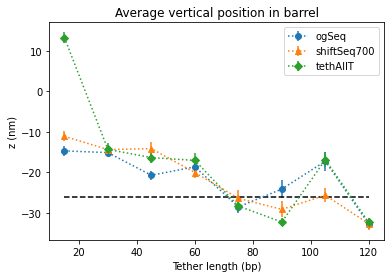

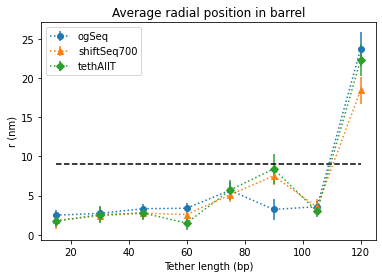

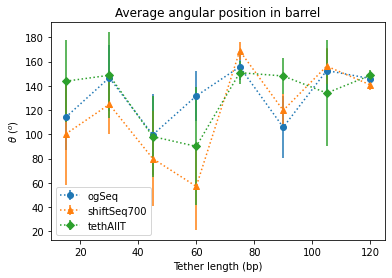

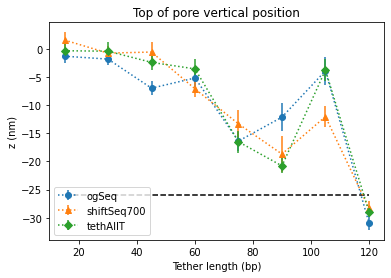

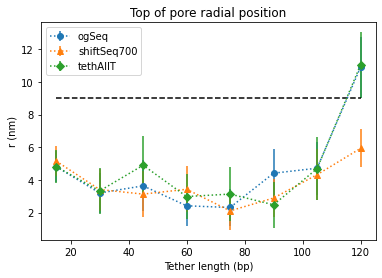

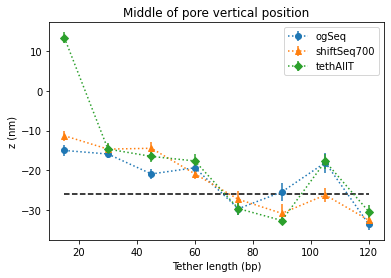

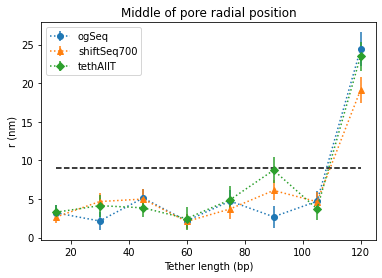

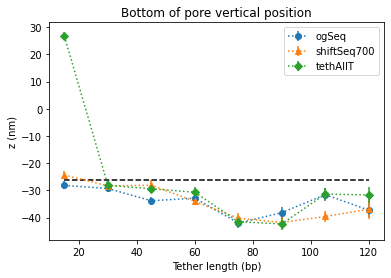

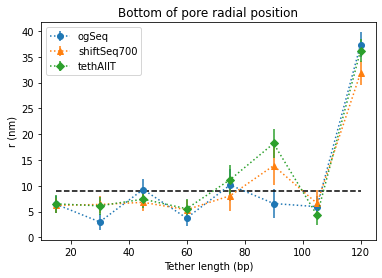

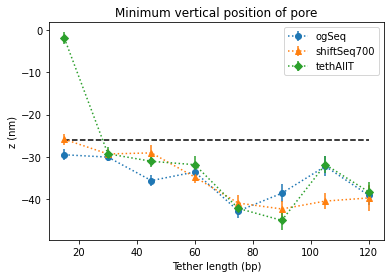

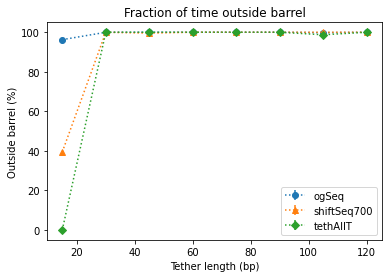

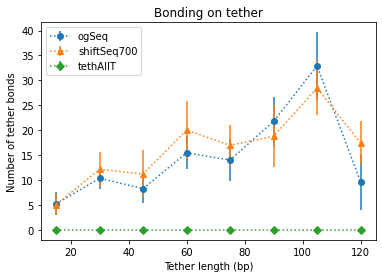

In [6]:
'''
Comparison between the different pores
'''

plotMeanStdEB(teth_lens, ave_z, std_z, ylabel = 'z (nm)', title = 'Average vertical position in barrel', hline = -26, legend = seqNames)
plotMeanStdEB(teth_lens, ave_r, std_r, ylabel = 'r (nm)', title = 'Average radial position in barrel', hline = 9, legend = seqNames)
plotMeanStdEB(teth_lens, ave_th, std_th, ylabel = r'$\theta$ ($^o$)', title = 'Average angular position in barrel', legend = seqNames)
plotMeanStdEB(teth_lens, ave_top_z, std_top_z, ylabel = 'z (nm)', title = 'Top of pore vertical position', hline = -26, legend = seqNames)
plotMeanStdEB(teth_lens, ave_top_r, std_top_r, ylabel = 'r (nm)', title = 'Top of pore radial position', hline = 9, legend = seqNames)
plotMeanStdEB(teth_lens, ave_mid_z, std_mid_z, ylabel = 'z (nm)', title = 'Middle of pore vertical position', hline = -26, legend = seqNames)
plotMeanStdEB(teth_lens, ave_mid_r, std_mid_r, ylabel = 'r (nm)', title = 'Middle of pore radial position', hline = 9, legend = seqNames)
plotMeanStdEB(teth_lens, ave_bot_z, std_bot_z, ylabel = 'z (nm)', title = 'Bottom of pore vertical position', hline = -26, legend = seqNames)
plotMeanStdEB(teth_lens, ave_bot_r, std_bot_r, ylabel = 'r (nm)', title = 'Bottom of pore radial position', hline = 9, legend = seqNames)
plotMeanStdEB(teth_lens, ave_min_z, std_min_z, ylabel = 'z (nm)', title = 'Minimum vertical position of pore', hline = -26, legend = seqNames)
plotMeanStdEB(teth_lens, 100*FracOut, 0*FracOut, ylabel = 'Outside barrel (%)', title = 'Fraction of time outside barrel', legend = seqNames)
plotMeanStdEB(teth_lens, ave_bonds, std_bonds, ylabel = 'Number of tether bonds', title = 'Bonding on tether', legend = seqNames)

# Conclusions



# Future work
